#1. Install & Import Libraries

In [5]:
!pip install -q kagglehub imbalanced-learn xgboost

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

#2. Download & Load Dataset

In [6]:
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/Churn_Modelling.csv")

100%|██████████| 262k/262k [00:00<00:00, 18.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/saurabhbadole/bank-customer-churn-prediction-dataset/versions/2


#3. Data Overview

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

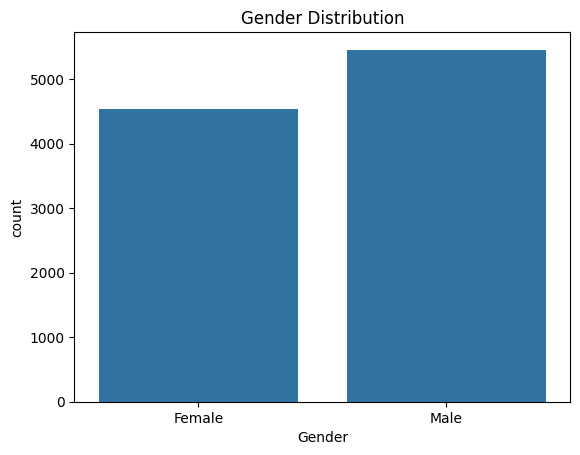

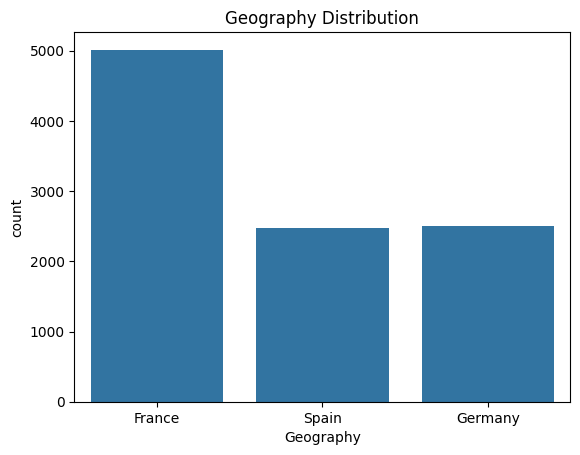

In [7]:
print(df.head())
print(df.info())
print(df.describe())

# Distribution of categorical features
sns.countplot(data=df, x='Gender')
plt.title("Gender Distribution")
plt.show()

sns.countplot(data=df, x='Geography')
plt.title("Geography Distribution")
plt.show()

#4. Missing Values Check

In [8]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


#5. Encode Categorical Variables

In [9]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])       # Male:1, Female:0
df['Geography'] = le.fit_transform(df['Geography']) # Unique integers

#6. Feature Scaling

In [10]:
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

#7. Label Imbalance Check

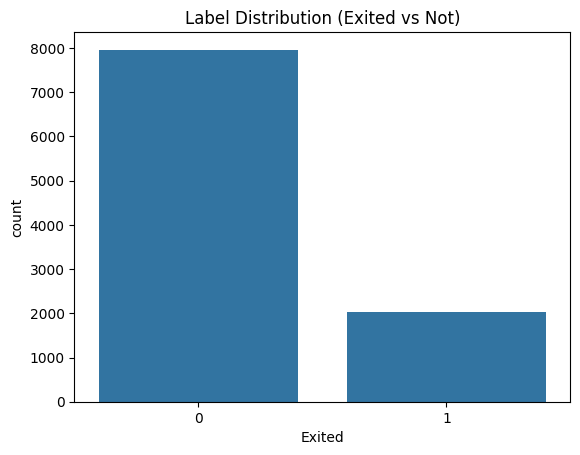

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


In [11]:
sns.countplot(data=df, x='Exited')
plt.title("Label Distribution (Exited vs Not)")
plt.show()

print(df['Exited'].value_counts(normalize=True))

#8. One-Dimensional Feature Analysis

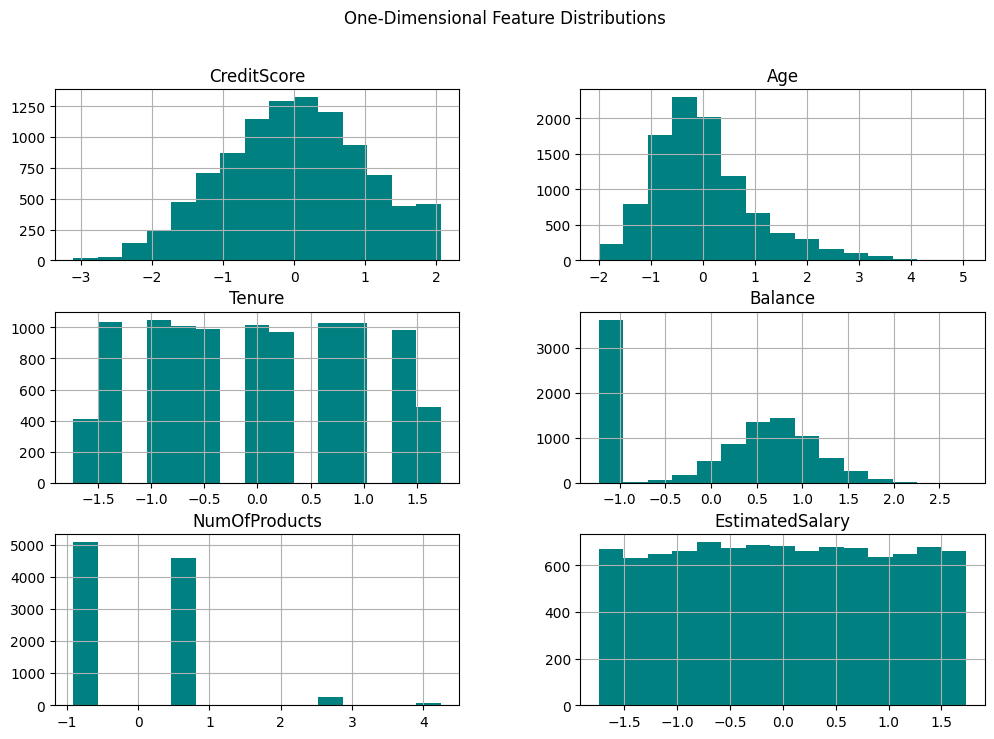

In [12]:
df[features].hist(bins=15, figsize=(12, 8), color='teal')
plt.suptitle("One-Dimensional Feature Distributions")
plt.show()

#9. Correlation Heatmap + Pairplot

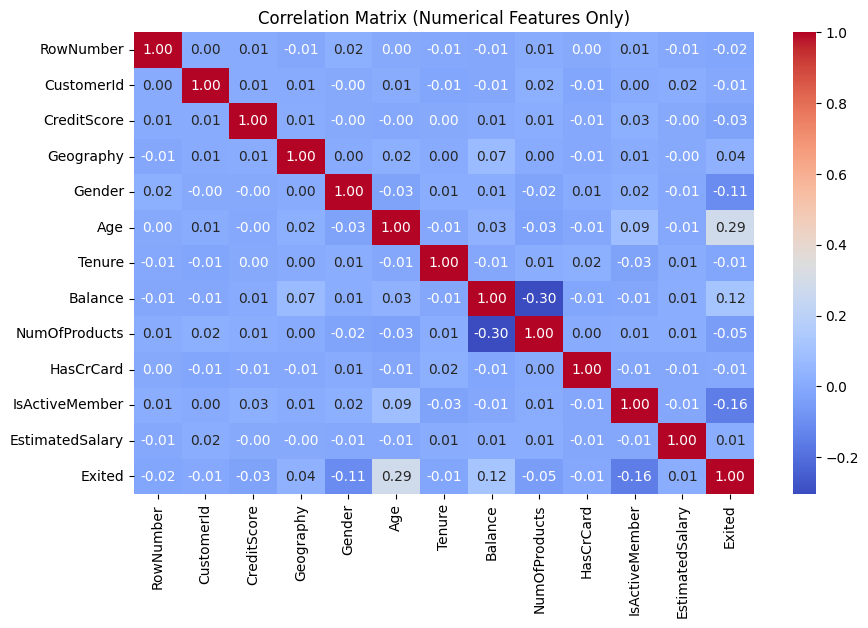

In [13]:
# Only use numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numerical Features Only)")
plt.show()

#10. PCA Visualization

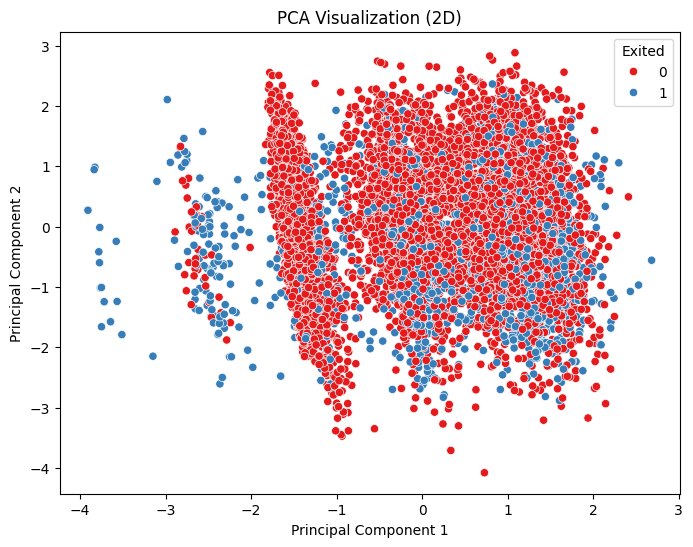

In [14]:
X_pca = df.drop(columns=['Exited', 'Surname', 'RowNumber', 'CustomerId'])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['Exited'], palette='Set1')
plt.title("PCA Visualization (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

10b. Two-Dimensional Analysis – Pairwise Relationships

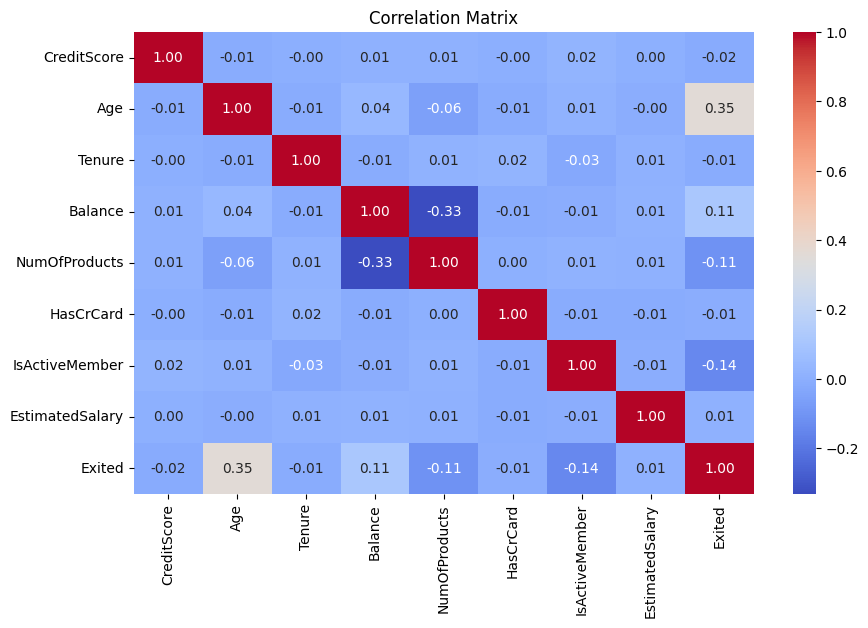

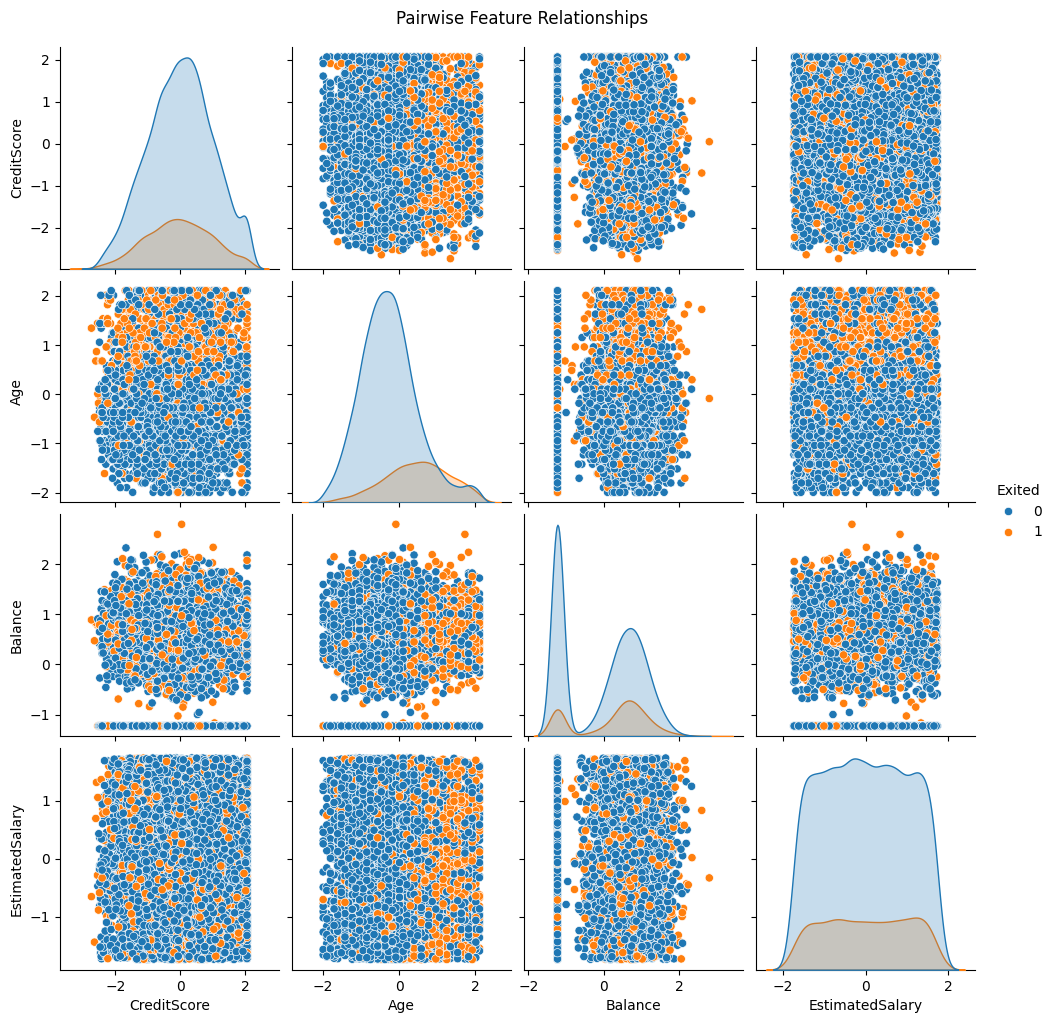

In [21]:
# Drop non-numeric columns for correlation heatmap
numeric_df = df_no_outliers.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography', 'Gender'], axis=1)

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Pairplot on selected numeric features
sns.pairplot(numeric_df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']], hue='Exited', diag_kind='kde')
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

Dimensionality reduction:

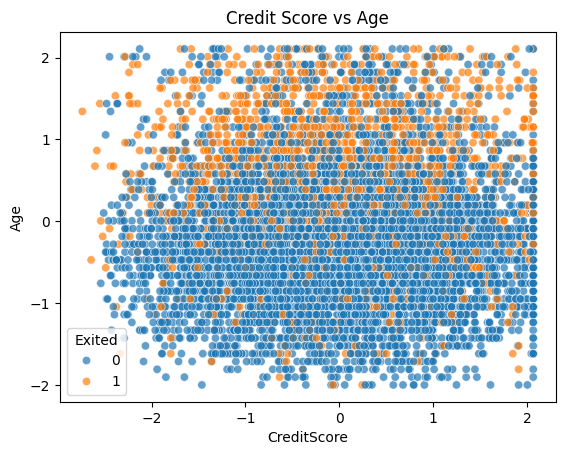

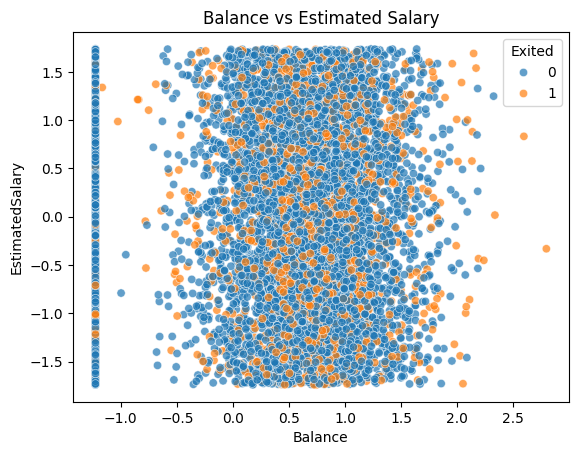

In [22]:
# Credit Score vs Age with churn as hue
sns.scatterplot(data=df_no_outliers, x='CreditScore', y='Age', hue='Exited', alpha=0.7)
plt.title("Credit Score vs Age")
plt.show()

# Balance vs EstimatedSalary with churn hue
sns.scatterplot(data=df_no_outliers, x='Balance', y='EstimatedSalary', hue='Exited', alpha=0.7)
plt.title("Balance vs Estimated Salary")
plt.show()

10c. Multi-Dimensional Analysis – Deeper Feature Interaction

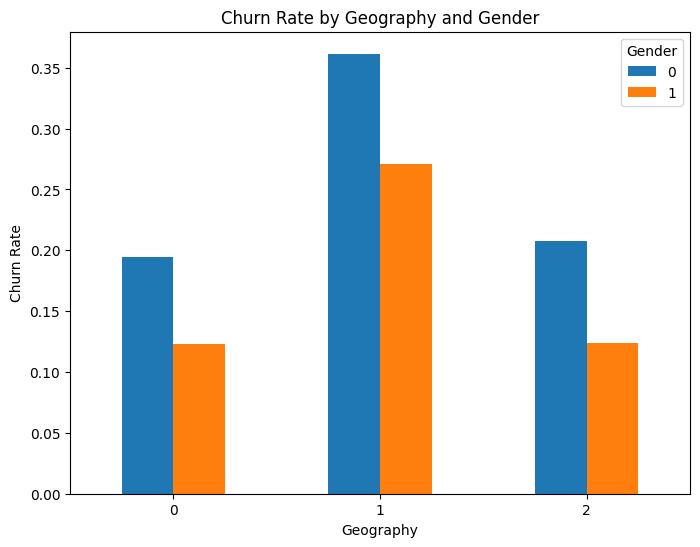

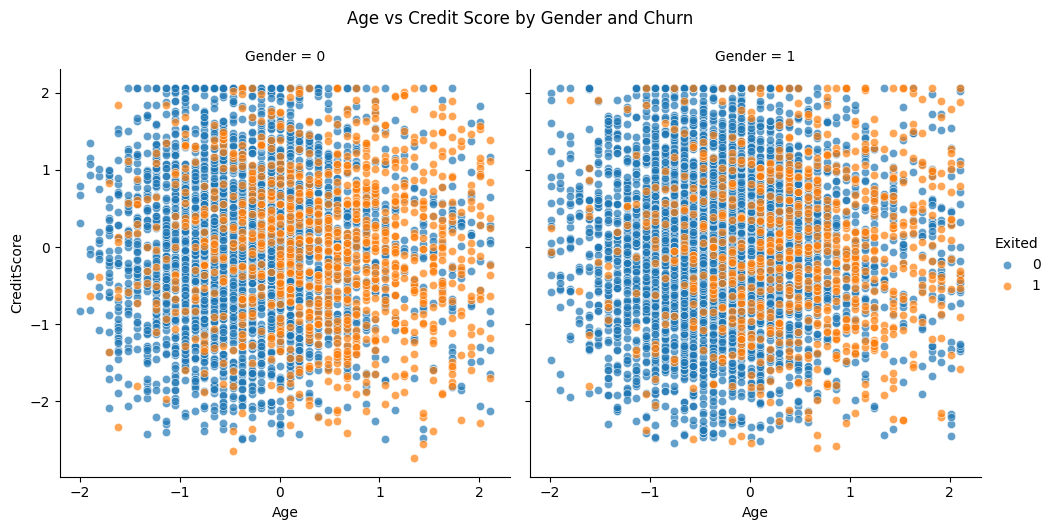

In [23]:
# Using pairwise groupings and advanced visualizations

# Example 1: Mean churn rate by Geography and Gender
churn_by_geo_gender = df_no_outliers.groupby(['Geography', 'Gender'])['Exited'].mean().unstack()
churn_by_geo_gender.plot(kind='bar', figsize=(8,6))
plt.title("Churn Rate by Geography and Gender")
plt.ylabel("Churn Rate")
plt.xticks(rotation=0)
plt.show()

# Example 2: FacetGrid on Age vs CreditScore colored by Exited, split by Gender
g = sns.FacetGrid(df_no_outliers, col="Gender", hue="Exited", height=5)
g.map(sns.scatterplot, "Age", "CreditScore", alpha=0.7)
g.add_legend()
g.fig.suptitle("Age vs Credit Score by Gender and Churn", y=1.05)
plt.show()

Dimensionality reductio:

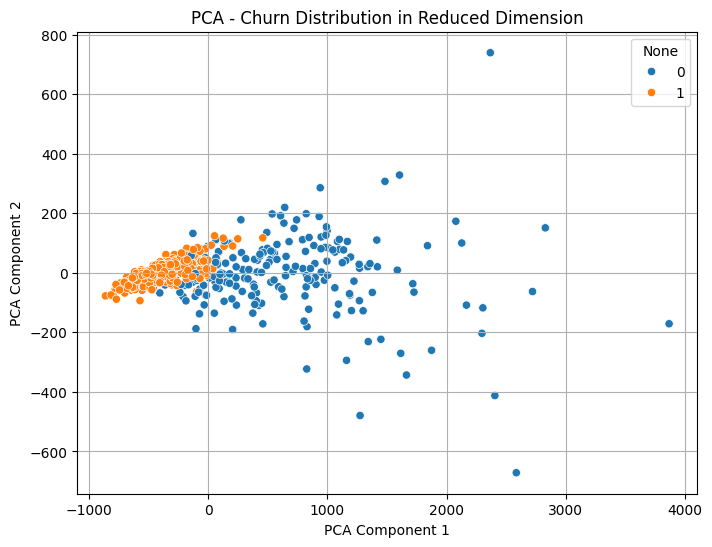

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA - Churn Distribution in Reduced Dimension")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

#11. Outlier Detection using IQR

In [20]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_no_outliers = remove_outliers(df.copy(), features)
print("Original size:", df.shape[0])
print("After outlier removal:", df_no_outliers.shape[0])

Original size: 10000
After outlier removal: 9515


#12. Split the Data

In [24]:
X = df_no_outliers.drop(columns=['Exited', 'Surname', 'RowNumber', 'CustomerId'])
y = df_no_outliers['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 7612, Test size: 1903


#13. Apply SMOTE (Handling Class Imbalance)

Class distribution after SMOTE:
Exited
1    6117
0    6117
Name: count, dtype: int64


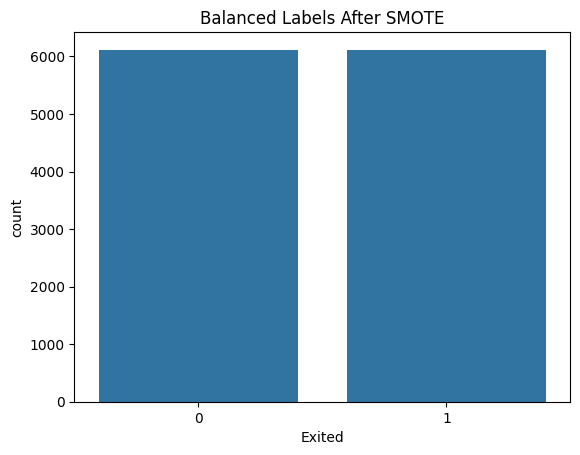

In [25]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

sns.countplot(x=y_train_smote)
plt.title("Balanced Labels After SMOTE")
plt.show()

#14. Model Training Multiple Models

In [26]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

trained_models = {}

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    trained_models[name] = model
    print(f"Trained: {name}")

Trained: Decision Tree
Trained: Random Forest
Trained: K-Nearest Neighbors
Trained: Support Vector Machine


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trained: XGBoost


#15. Evaluation Function

In [27]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Model: {name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc

#16. Evaluate All Models


 Model: Decision Tree
Accuracy: 0.7598528638991067
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1529
           1       0.41      0.53      0.47       374

    accuracy                           0.76      1903
   macro avg       0.65      0.67      0.66      1903
weighted avg       0.79      0.76      0.77      1903



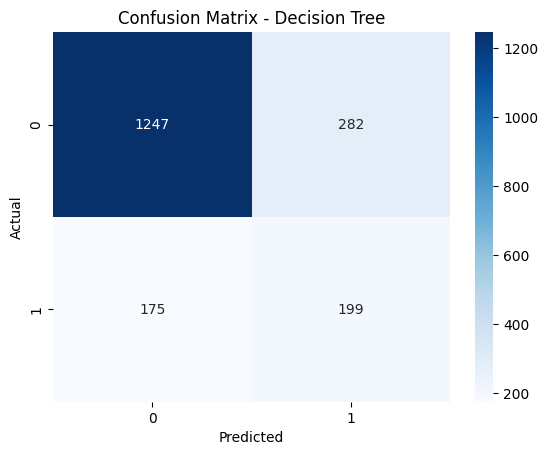


 Model: Random Forest
Accuracy: 0.8302679978980557
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1529
           1       0.57      0.58      0.57       374

    accuracy                           0.83      1903
   macro avg       0.73      0.73      0.73      1903
weighted avg       0.83      0.83      0.83      1903



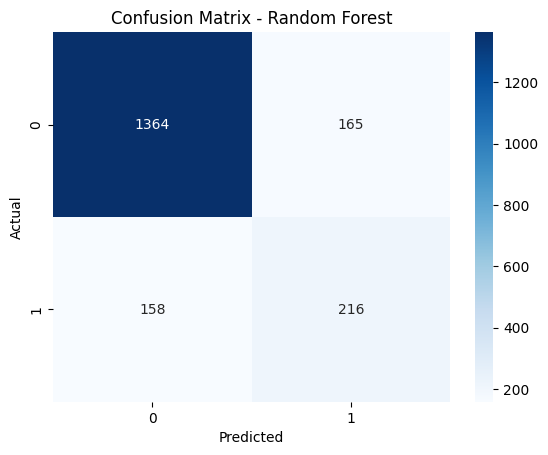


 Model: K-Nearest Neighbors
Accuracy: 0.744088281660536
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1529
           1       0.41      0.68      0.51       374

    accuracy                           0.74      1903
   macro avg       0.66      0.72      0.67      1903
weighted avg       0.81      0.74      0.76      1903



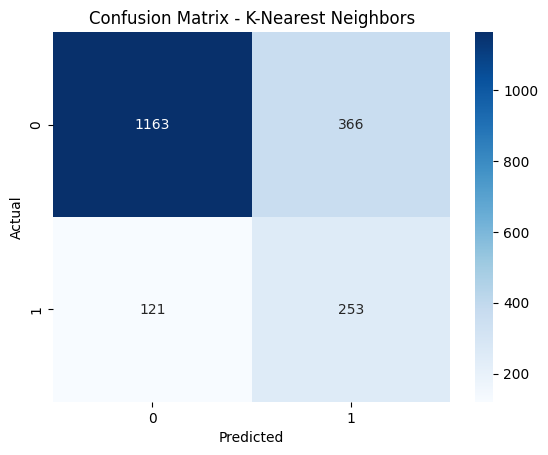


 Model: Support Vector Machine
Accuracy: 0.7798213347346296
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1529
           1       0.46      0.70      0.55       374

    accuracy                           0.78      1903
   macro avg       0.69      0.75      0.70      1903
weighted avg       0.83      0.78      0.79      1903



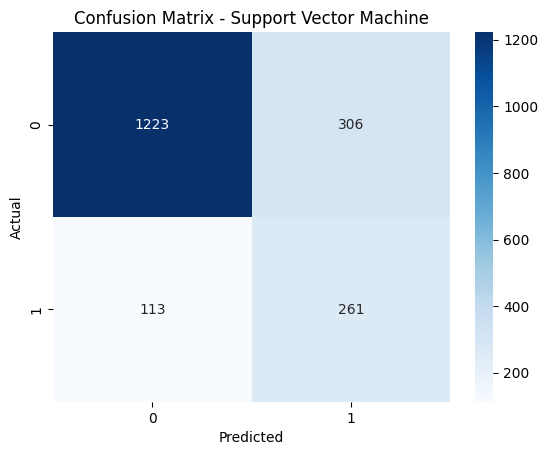


 Model: XGBoost
Accuracy: 0.8360483447188649
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1529
           1       0.59      0.54      0.56       374

    accuracy                           0.84      1903
   macro avg       0.74      0.72      0.73      1903
weighted avg       0.83      0.84      0.83      1903



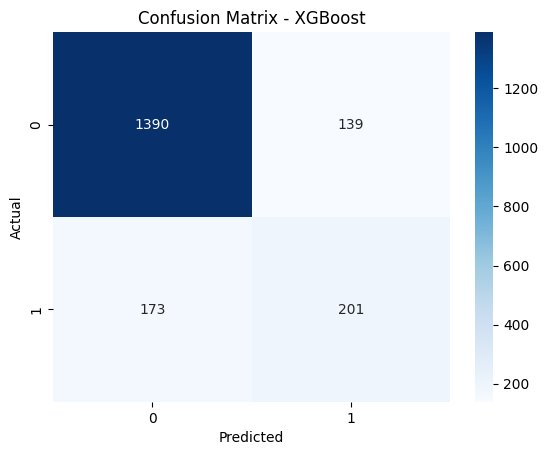

In [28]:
model_accuracies = {}

for name, model in trained_models.items():
    acc = evaluate_model(name, model, X_test, y_test)
    model_accuracies[name] = acc

#17. Accuracy Comparison Plot

<ipython-input-29-9449670ada9b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='viridis')


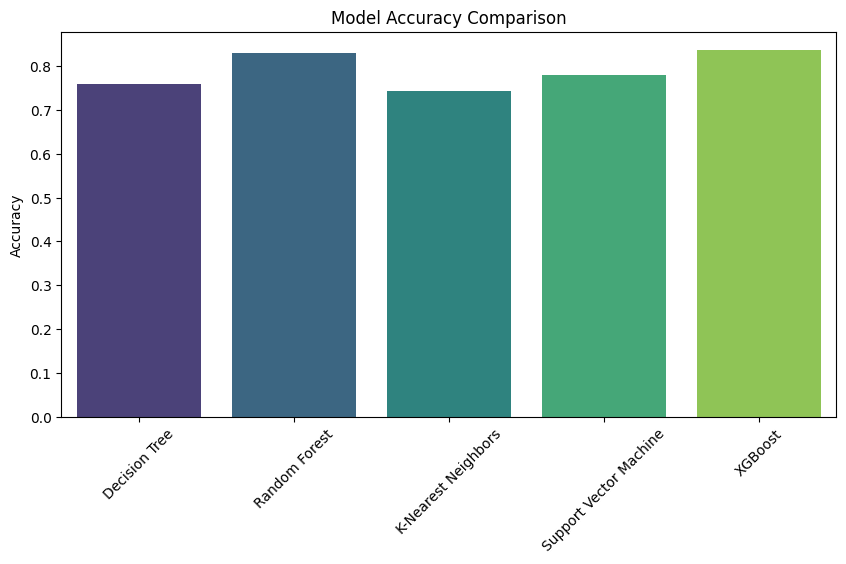

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

#18. Voting Classifier – Ensemble Approach

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Model: Voting Classifier
Accuracy: 0.8276405675249606
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1529
           1       0.56      0.58      0.57       374

    accuracy                           0.83      1903
   macro avg       0.73      0.74      0.73      1903
weighted avg       0.83      0.83      0.83      1903



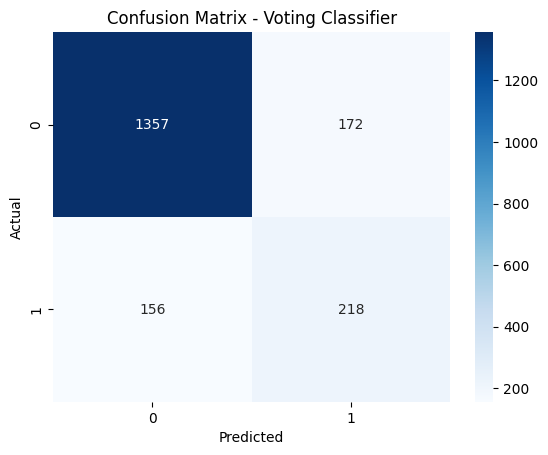

0.8276405675249606

In [30]:
ensemble = VotingClassifier(estimators=[
    ('rf', trained_models["Random Forest"]),
    ('xgb', trained_models["XGBoost"]),
    ('knn', trained_models["K-Nearest Neighbors"])
], voting='hard')

ensemble.fit(X_train_smote, y_train_smote)

evaluate_model("Voting Classifier", ensemble, X_test, y_test)

19. Predict on Test Set

In [31]:
y_pred_final = ensemble.predict(X_test)
final_acc = accuracy_score(y_test, y_pred_final)
print(" Final Ensemble Accuracy:", final_acc)

 Final Ensemble Accuracy: 0.8276405675249606


#SMOTE

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ----------------------------
# STEP 1: Clean and Prepare Data
# ----------------------------
df_model = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_model['Geography'] = LabelEncoder().fit_transform(df_model['Geography'])
df_model['Gender'] = LabelEncoder().fit_transform(df_model['Gender'])

X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

# Train-test split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# ----------------------------
# STEP 2: Evaluation Function
# ----------------------------
def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    return {
        'Accuracy': accuracy_score(y_te, y_pred),
        'Recall': recall_score(y_te, y_pred),
        'Precision': precision_score(y_te, y_pred),
        'F1-score': f1_score(y_te, y_pred)
    }

# ----------------------------
# STEP 3: Run all models
# ----------------------------
results_no_smote = {}
results_with_smote = {}

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

for name, model in models.items():
    print(f"Training {name}...")

    # Without SMOTE
    results_no_smote[name] = evaluate(model, X_train, y_train, X_test, y_test)

    # With SMOTE
    results_with_smote[name] = evaluate(model, X_train_smote, y_train_smote, X_test, y_test)

# ----------------------------
# STEP 4: Display Results
# ----------------------------
import pandas as pd

df_results_no_smote = pd.DataFrame(results_no_smote).T
df_results_with_smote = pd.DataFrame(results_with_smote).T

print("\nWITHOUT SMOTE:\n", df_results_no_smote.round(4))
print("\nWITH SMOTE:\n", df_results_with_smote.round(4))

Training KNN...
Training SVC...
Training Decision Tree...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



WITHOUT SMOTE:
                Accuracy  Recall  Precision  F1-score
KNN               0.846  0.4555     0.6557    0.5375
SVC               0.858  0.3664     0.8045    0.5035
Decision Tree     0.781  0.5267     0.4510    0.4859
Random Forest     0.864  0.4656     0.7469    0.5737
XGBoost           0.861  0.5064     0.7032    0.5888

WITH SMOTE:
                Accuracy  Recall  Precision  F1-score
KNN              0.7535  0.6845     0.4216    0.5218
SVC              0.7980  0.7430     0.4908    0.5911
Decision Tree    0.7665  0.5369     0.4254    0.4747
Random Forest    0.8470  0.6234     0.6079    0.6156
XGBoost          0.8555  0.5674     0.6520    0.6068


#20. Feature Importance (Random Forest)

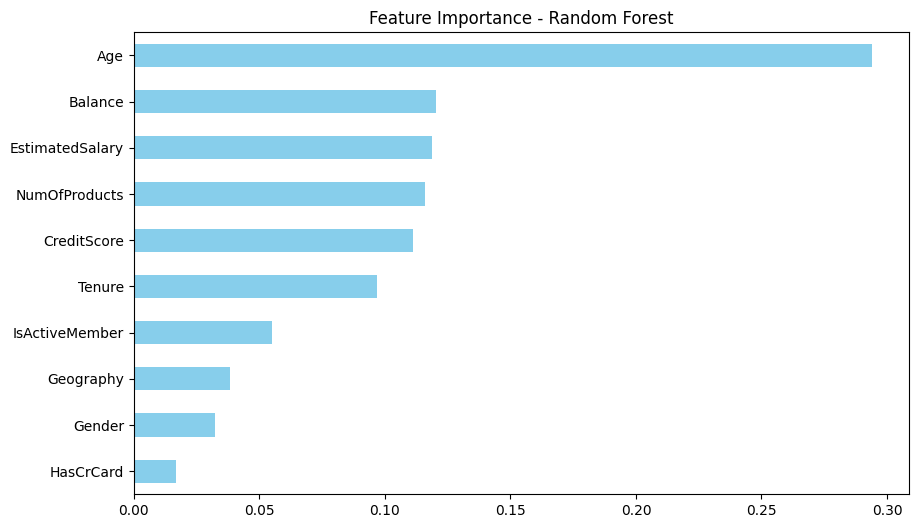

In [33]:
feat_imp = pd.Series(trained_models["Random Forest"].feature_importances_, index=X.columns)
feat_imp.sort_values(ascending=True).plot(kind='barh', figsize=(10,6), color='skyblue')
plt.title("Feature Importance - Random Forest")
plt.show()

#21. Model Probabilities and ROC Curve (Optional)

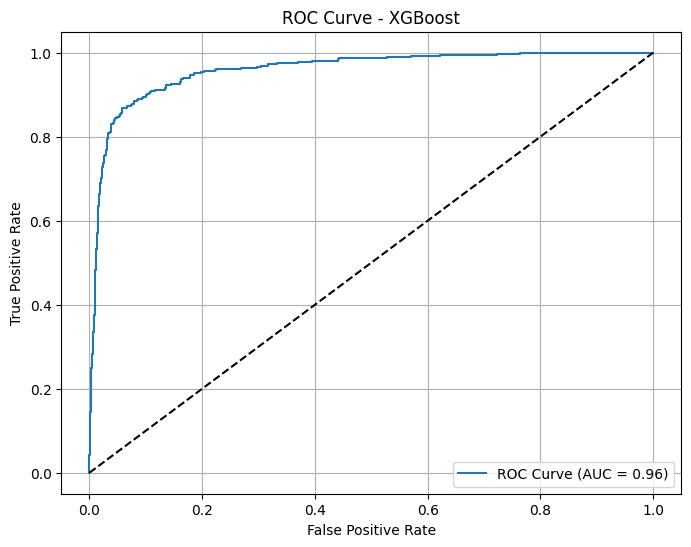

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

probs = trained_models["XGBoost"].predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, probs):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

#22. Save Final Model (Optional)

In [35]:
import joblib
joblib.dump(ensemble, "final_churn_model.pkl")

['final_churn_model.pkl']

#23. Summary of Results

In [36]:
summary_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=["Accuracy"])
summary_df = summary_df.sort_values("Accuracy", ascending=False)
print("\nModel Performance Summary:")
print(summary_df)


Model Performance Summary:
                        Accuracy
XGBoost                 0.836048
Random Forest           0.830268
Support Vector Machine  0.779821
Decision Tree           0.759853
K-Nearest Neighbors     0.744088


#24. Predict on a Sample User

In [37]:
sample = X_test.iloc[0].values.reshape(1, -1)
print("Sample User Data:\n", sample)
pred = ensemble.predict(sample)
print("Predicted Churn (0=No, 1=Yes):", pred[0])

Sample User Data:
 [[-0.56419726  1.          1.         -0.66001848 -0.69598177  0.32411912
   0.80773656  0.          0.         -1.01381126]]
Predicted Churn (0=No, 1=Yes): 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Size of the dataset: (10000, 14)

Missing Values:
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Unique count of variables:
 RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64
   RowNumber  CustomerId   Surname  CreditScore  Geography  Gender       Age  \
0          1    15634602  Hargrave    -0.326221          0       0  0.293517   
1          2    15647311      Hill    -0.440036          2       0  0.198164   
2         

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7976 - loss: 0.5780
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8025 - loss: 0.4327
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7967 - loss: 0.4409
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7966 - loss: 0.4268
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8231 - loss: 0.4269
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8317 - loss: 0.4194
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8365 - loss: 0.4156
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8287 - loss: 0.4203
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8370 - loss: 0.4092
Epoch 10/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8315 - loss: 0.4158
Epoch 11/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8256 - loss: 0.4232
Epoch 12/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

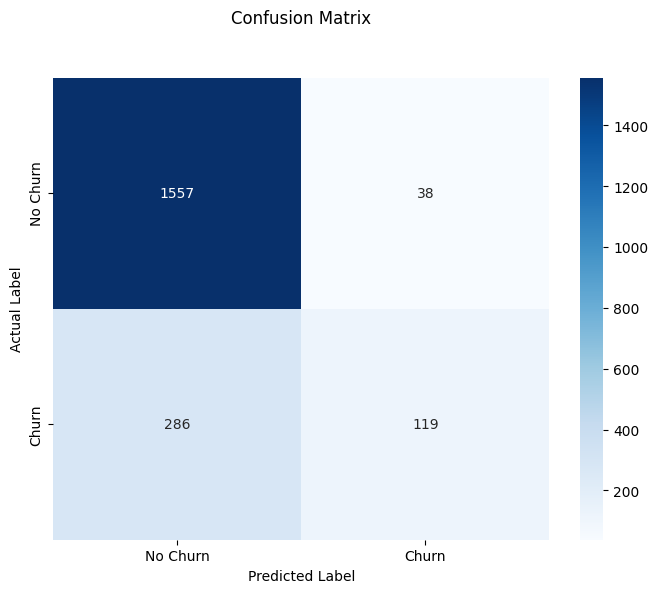


Accuracy Score: 83.80%


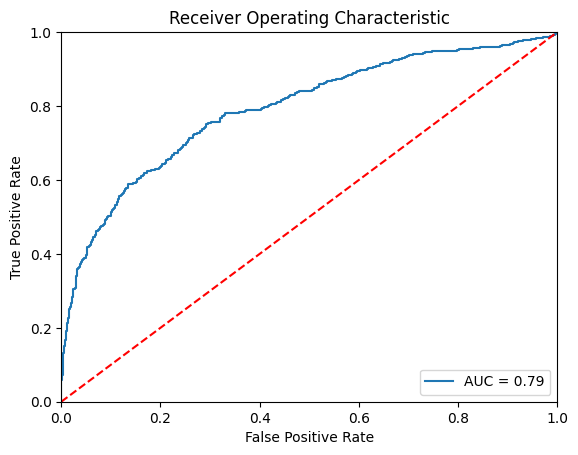


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1595
           1       0.76      0.29      0.42       405

    accuracy                           0.84      2000
   macro avg       0.80      0.64      0.66      2000
weighted avg       0.83      0.84      0.81      2000

Test Set Performance Metrics:
Accuracy Score : 0.8380
Precision Score: 0.7580
Recall Score   : 0.2938
F1 Score       : 0.4235


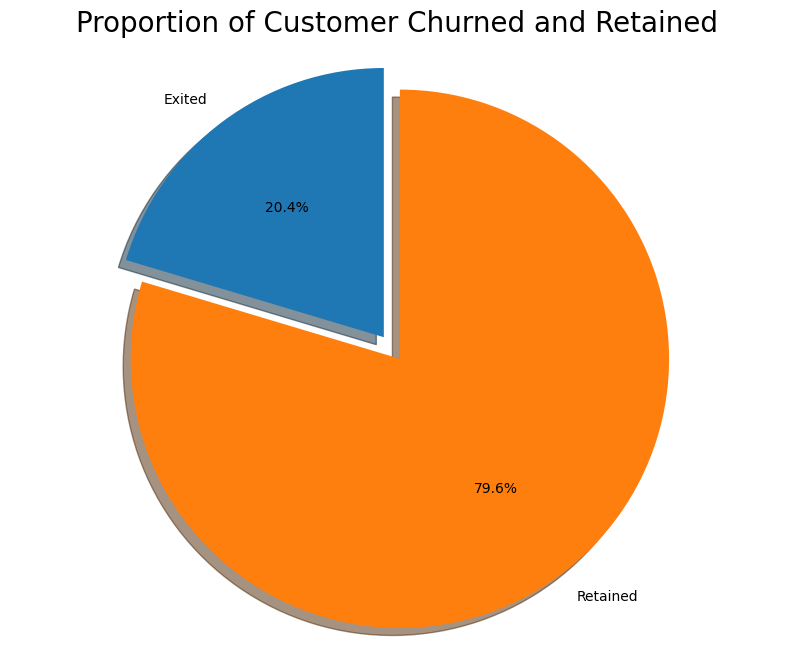

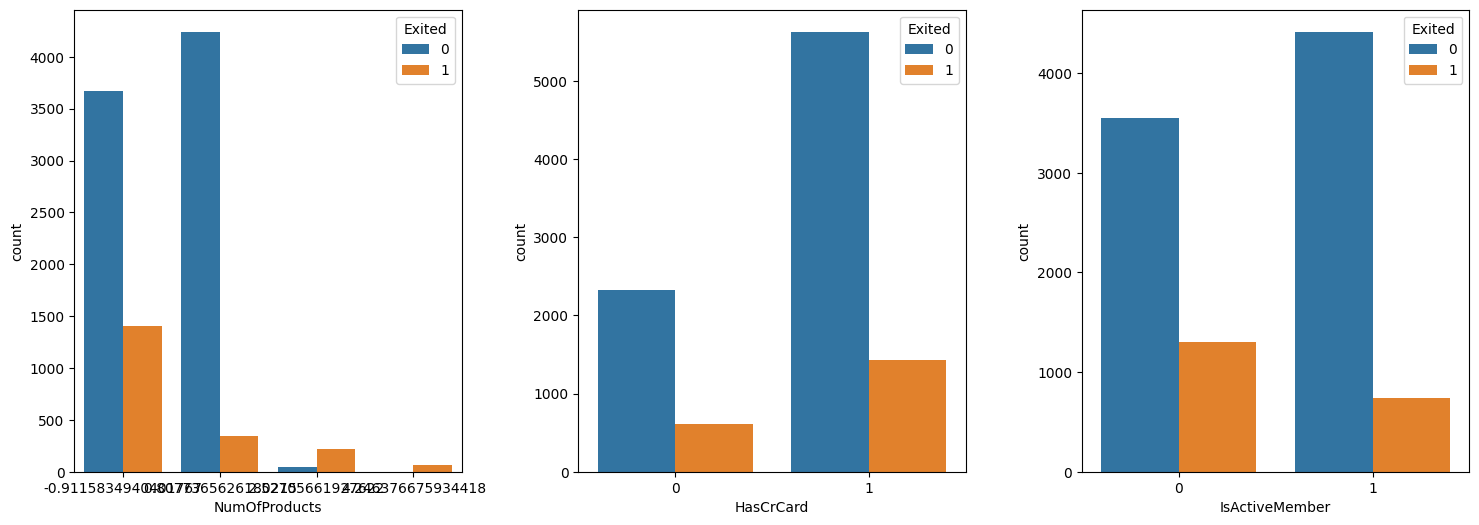

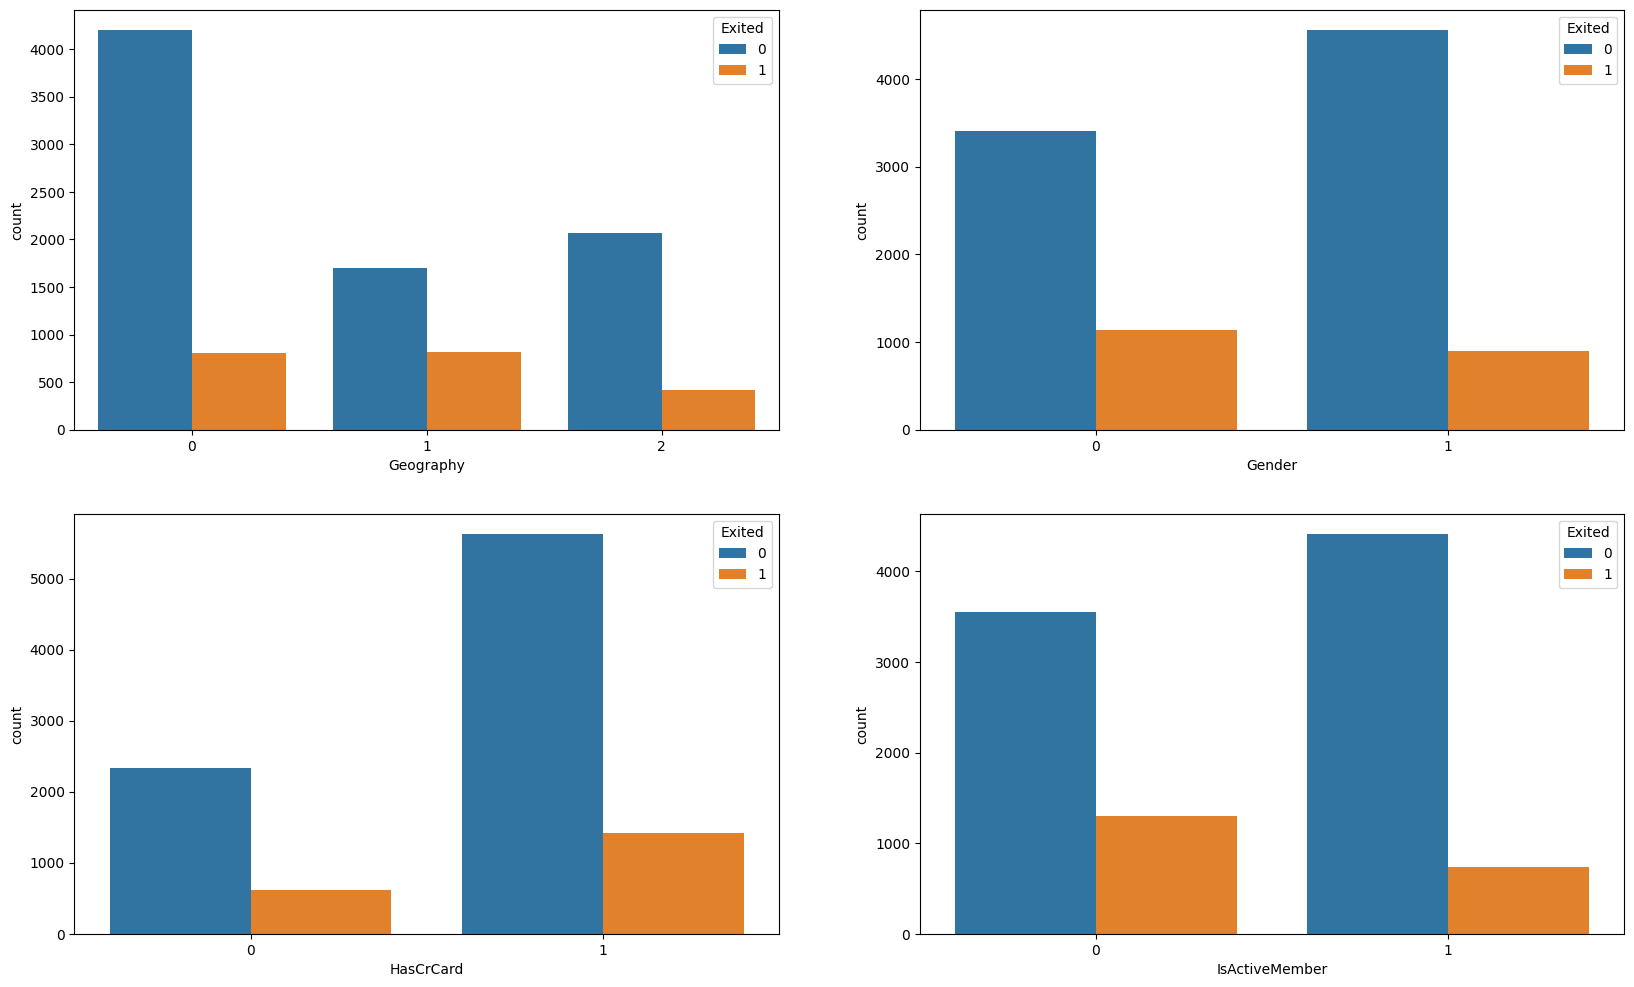

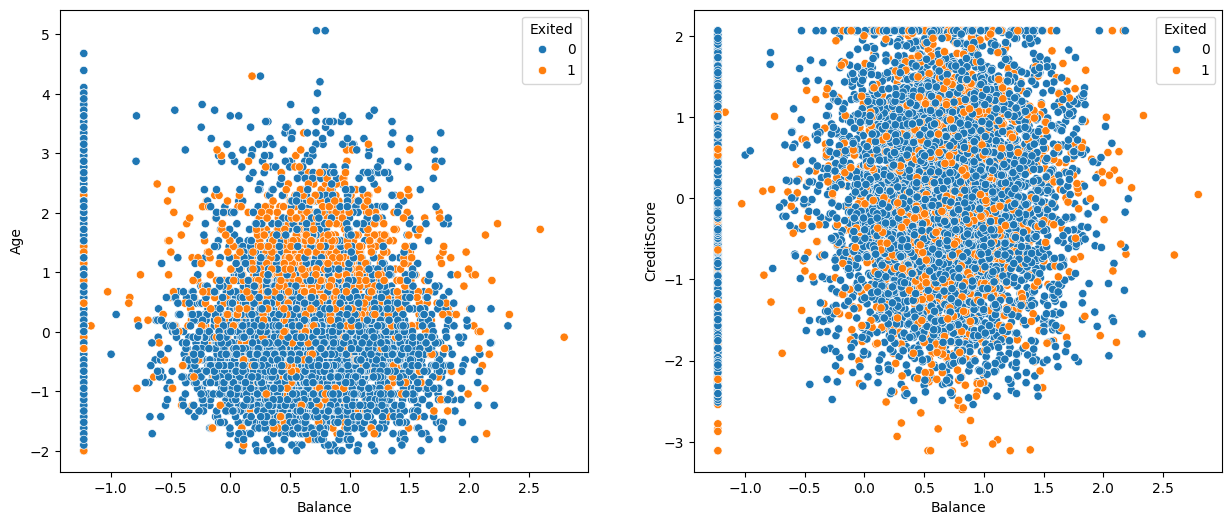

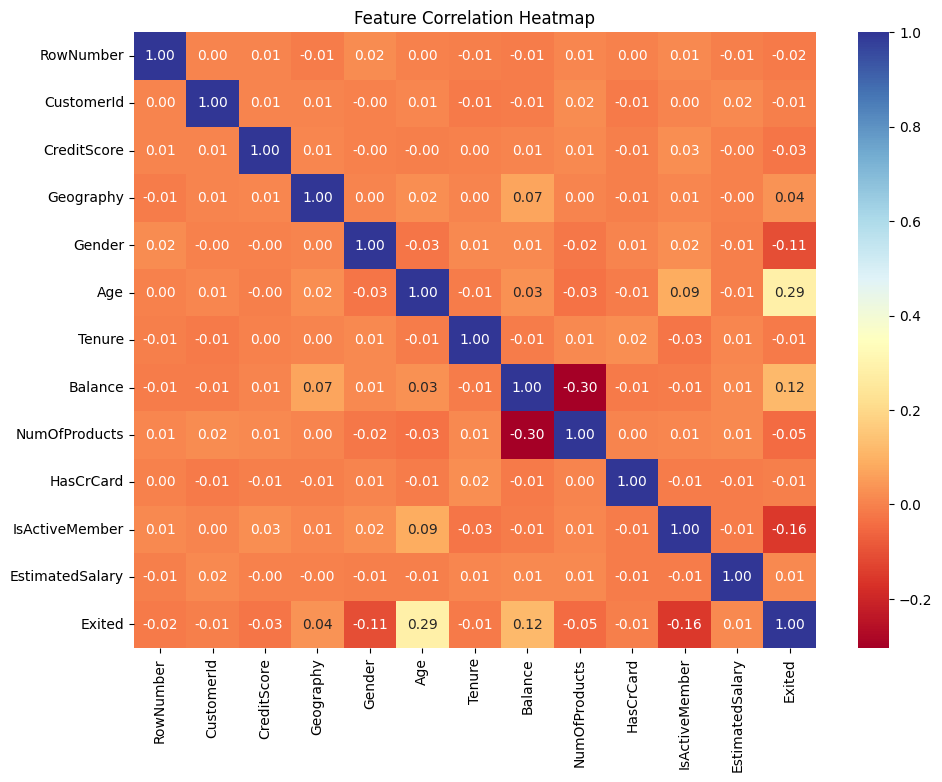

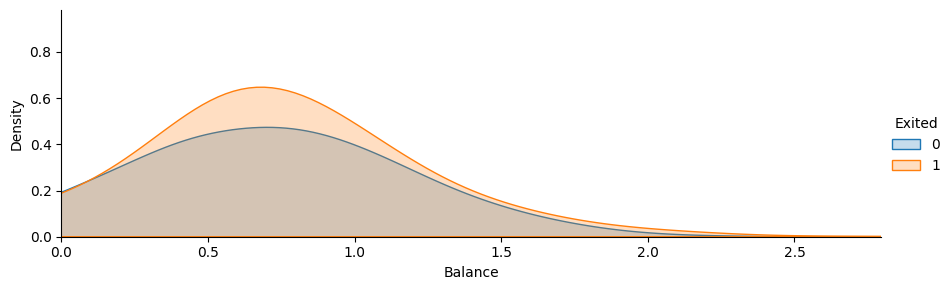

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 61.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 51.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 74.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


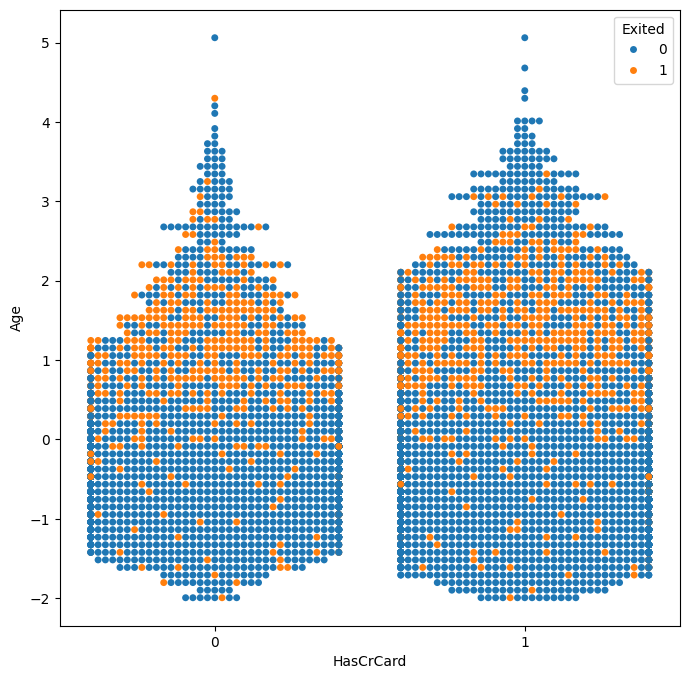

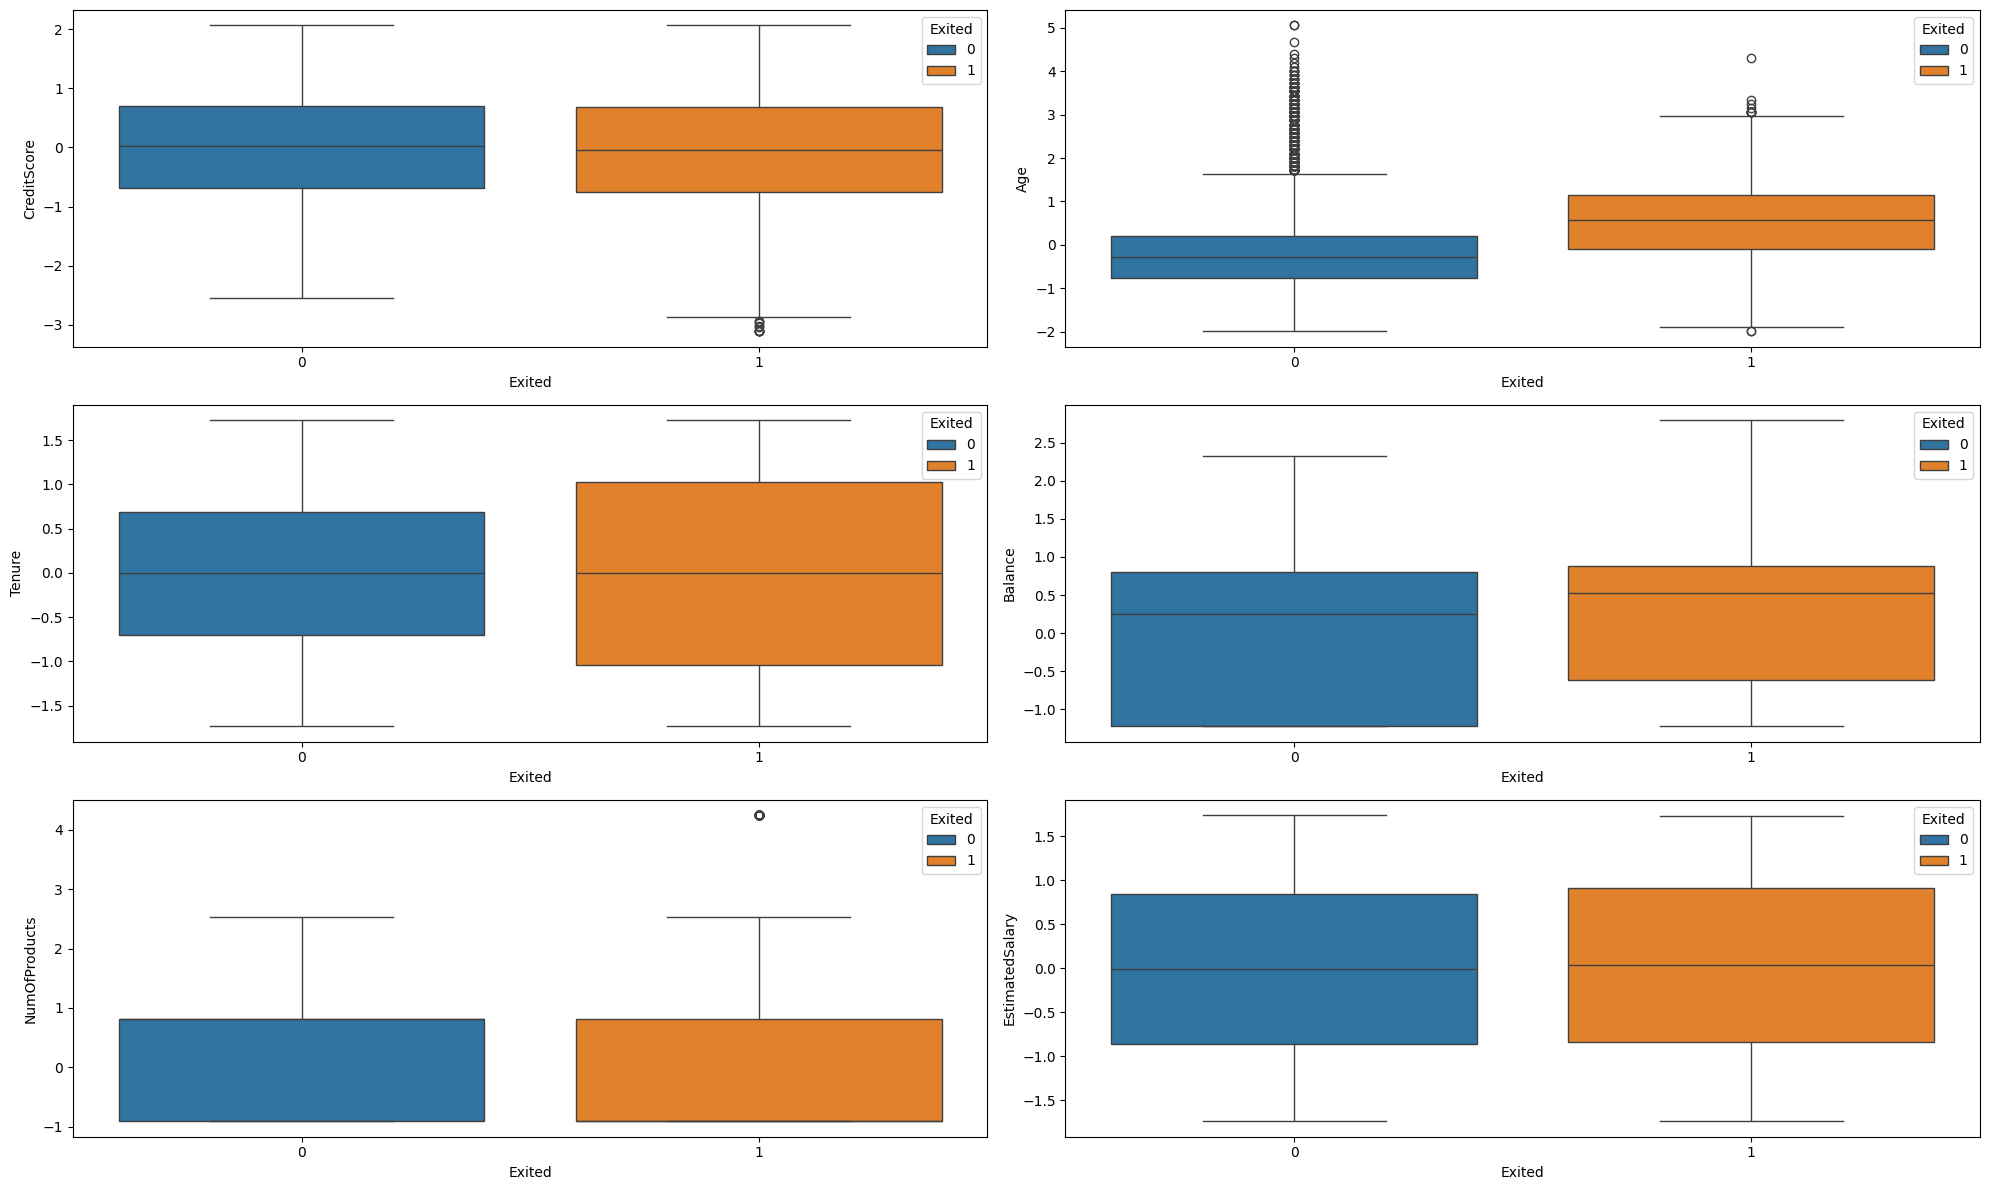

In [38]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from keras.models import Sequential
from keras.layers import Dense

# Display options
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Updated feature names and target
feature_names = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
                 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
X = df[feature_names]
y = df["Exited"]

# Basic dataset info
print("Size of the dataset:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique count of variables:\n", df.nunique())
print(df.head())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# ANN model
classifier = Sequential()
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=9))
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

# Predict
y_pred = classifier.predict(X_test)
y_pred_rounded = y_pred.round()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rounded)
cm_df = pd.DataFrame(cm, index=["No Churn", "Churn"], columns=["No Churn", "Churn"])

# Heatmap of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix", y=1.1)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred_rounded)
print(f"\nAccuracy Score: {accuracy * 100:.2f}%")

# ROC Curve
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Classification Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rounded))

print("Test Set Performance Metrics:")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred_rounded):.4f}")
print(f"Precision Score: {precision_score(y_test, y_pred_rounded):.4f}")
print(f"Recall Score   : {recall_score(y_test, y_pred_rounded):.4f}")
print(f"F1 Score       : {f1_score(y_test, y_pred_rounded):.4f}")

# Pie chart
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited'] == 1].count(), df.Exited[df['Exited'] == 0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Customer Churned and Retained", size=20)
plt.show()

# Count plots
_, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
sns.countplot(x="NumOfProducts", hue="Exited", data=df, ax=ax[0])
sns.countplot(x="HasCrCard", hue="Exited", data=df, ax=ax[1])
sns.countplot(x="IsActiveMember", hue="Exited", data=df, ax=ax[2])

# More count plots
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue='Exited', data=df, ax=axarr[0][0])
sns.countplot(x='Gender', hue='Exited', data=df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axarr[1][1])

# Scatter plots
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x="Balance", y="Age", data=df, hue="Exited", ax=ax[0])
sns.scatterplot(x="Balance", y="CreditScore", data=df, hue="Exited", ax=ax[1])

# Correlation heatmap
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(11, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="RdYlBu", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# KDE plot for balance
facet = sns.FacetGrid(df, hue="Exited", aspect=3)
facet.map(sns.kdeplot, "Balance", fill=True)
facet.set(xlim=(0, df["Balance"].max()))
facet.add_legend()
plt.show()

# Swarm plot
plt.figure(figsize=(8, 8))
sns.swarmplot(x="HasCrCard", y="Age", data=df, hue="Exited")

# Box plots
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore', x='Exited', hue='Exited', data=df, ax=axarr[0][0])
sns.boxplot(y='Age', x='Exited', hue='Exited', data=df, ax=axarr[0][1])
sns.boxplot(y='Tenure', x='Exited', hue='Exited', data=df, ax=axarr[1][0])
sns.boxplot(y='Balance', x='Exited', hue='Exited', data=df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts', x='Exited', hue='Exited', data=df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary', x='Exited', hue='Exited', data=df, ax=axarr[2][1])
plt.tight_layout()
plt.show()

Path to dataset files: /kaggle/input/bank-customer-churn-prediction-dataset

Evaluating Without SMOTE...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:01:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Evaluating With SMOTE...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:01:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:04:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Summary:
                            Model  Accuracy  Precision    Recall  F1 Score
0  VotingClassifier Without SMOTE    0.8593   0.818043  0.398145  0.535301
1     VotingClassifier With SMOTE    0.8158   0.537641  0.698585  0.607328


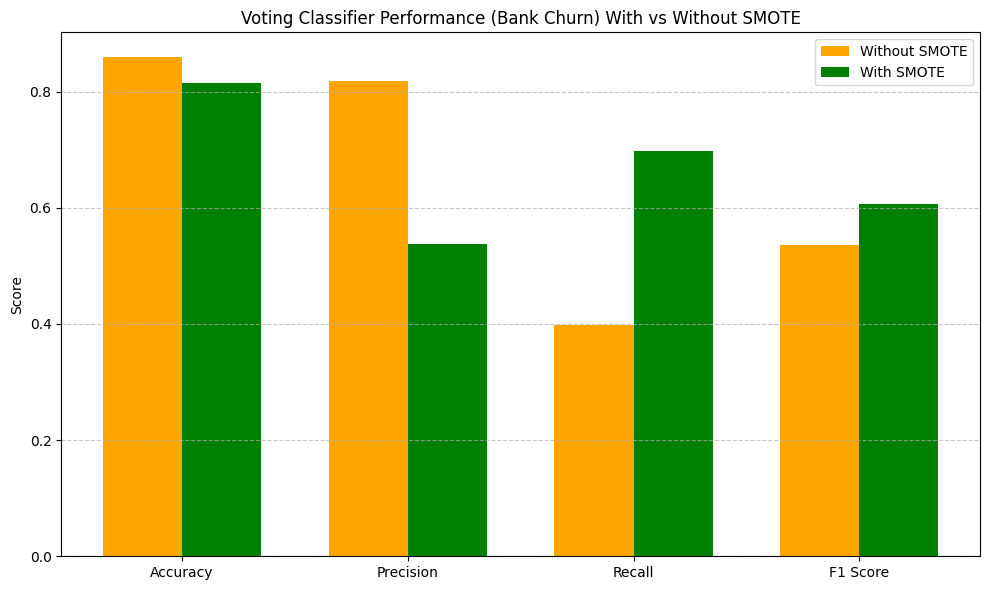

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Load dataset
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/Churn_Modelling.csv")

# Data preprocessing
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# Encode categorical variables
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models with optimized parameters
clf1 = LogisticRegression(C=0.5, max_iter=1000)
clf2 = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42)
clf3 = SVC(probability=True, C=1, gamma='scale')
clf4 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.1, max_depth=4, n_estimators=100)

# Voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3), ('xgb', clf4)],
    voting='soft'
)

# Scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipelines
pipeline_no_smote = Pipeline([
    ('model', voting_clf)
])

pipeline_with_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', voting_clf)
])

# Evaluate both models
print("\nEvaluating Without SMOTE...")
scores_no_smote = cross_validate(pipeline_no_smote, X_scaled, y, cv=cv, scoring=scoring)

print("\nEvaluating With SMOTE...")
scores_smote = cross_validate(pipeline_with_smote, X_scaled, y, cv=cv, scoring=scoring)

# Prepare results
def summarize(scores_dict):
    return {
        'Accuracy': np.mean(scores_dict['test_accuracy']),
        'Precision': np.mean(scores_dict['test_precision']),
        'Recall': np.mean(scores_dict['test_recall']),
        'F1 Score': np.mean(scores_dict['test_f1']),
    }

results = [
    {'Model': 'VotingClassifier Without SMOTE', **summarize(scores_no_smote)},
    {'Model': 'VotingClassifier With SMOTE', **summarize(scores_smote)}
]

df_results = pd.DataFrame(results)
print("\nSummary:")
print(df_results)

# Plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, df_results.loc[0, metrics], width, label='Without SMOTE', color='orange')
plt.bar(x + width/2, df_results.loc[1, metrics], width, label='With SMOTE', color='green')

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Voting Classifier Performance (Bank Churn) With vs Without SMOTE")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [46]:
# 🔮 Predicting churn: Final test predictions with SMOTE pipeline
final_preds = pipeline_with_smote.predict(X_test)
final_probs = pipeline_with_smote.predict_proba(X_test)[:, 1]

# 🧾 Create DataFrame with predictions
churn_results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': final_preds,
    'Churn_Probability': final_probs
})

# 🧠 Label as 'Churned' or 'Stayed'
churn_results['Predicted_Label'] = churn_results['Predicted'].map({0: 'Stayed', 1: 'Churned'})
churn_results['Actual_Label'] = churn_results['Actual'].map({0: 'Stayed', 1: 'Churned'})

# 👀 Show top 10 predictions
print("\n🔍 Sample Predictions on Test Set:")
print(churn_results.head(10))


🔍 Sample Predictions on Test Set:
   Actual  Predicted  Churn_Probability Predicted_Label Actual_Label
0       0          0           0.141032          Stayed       Stayed
1       0          0           0.272323          Stayed       Stayed
2       0          0           0.165268          Stayed       Stayed
3       0          0           0.208317          Stayed       Stayed
4       0          0           0.301957          Stayed       Stayed
5       0          0           0.303519          Stayed       Stayed
6       0          0           0.150337          Stayed       Stayed
7       0          1           0.551359         Churned       Stayed
8       0          1           0.787263         Churned       Stayed
9       0          0           0.243558          Stayed       Stayed
